In [2]:
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark
import boto3

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).getOrCreate()
#spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).master("local[*]").getOrCreate()

import pandas as pd
import numpy as np
import re
import sys
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

batch_size = 126

In [2]:
path = 's3a://fetch-data-puddle/spark/sandbox/mingjun/'

#train = spark.read.csv(path + 'ORtrainCSV', header=True).toPandas()

#test = spark.read.csv(path + 'ORtestCSV', header=True).toPandas()
#display(train.columns)

#other = spark.read.csv(path + 'ORotherCSV', header=True).toPandas()
#display(train.columns)


In [3]:
train = pd.read_csv('../train.csv', header=0).drop(['tenure_seeds', 'recency_seeds', 'dollars_seeds', 'units_seeds', 'trips_seeds',],axis=1)
print (train.shape)

test = pd.read_csv('../test.csv', header=0).drop(['tenure_seeds', 'recency_seeds', 'dollars_seeds', 'units_seeds', 'trips_seeds',],axis=1)
print (test.shape)

(60480, 2287)
(6781, 2287)


In [4]:
X_vars = list(train.columns[3:-1])
y_var = list(train.columns)[-1]
#print (X_vars)
#print (y_var)
x_train, x_test, y_train, y_test = train_test_split(train[X_vars].values, train[y_var].values, test_size=0.10, random_state=100)
print (x_train.shape)
print (y_train.shape)
n_columns = x_train.shape[1]
print (n_columns)

(54432, 2283)
(54432,)
2283


In [5]:
class ORDataset(Dataset):
    ## Define the underline data source
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])
        
dataset_train = ORDataset(x_train, y_train)

print ('Number of training set: ', len(dataset_train))
dataLoader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)

dataset_test = ORDataset(x_test, y_test)
print ('Number of test data set: ', len(dataset_test))
dataLoader_test = DataLoader(dataset_test, batch_size=len(y_test), shuffle=True, num_workers=1)

Number of training set:  54432
Number of test data set:  6048


In [36]:
if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

In [37]:
##Load the model simulator
class Simulator(nn.Module):
    def __init__(self, input_size, layers=1):
        super(Simulator, self).__init__()       
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.linear(x.float())
        out = torch.sigmoid(out)
        return out

## This serves as the simulator
simulator = Simulator(test.values[:,3:-1].shape[1])
simulator.load_state_dict(torch.load('../mode_lrAllVars.tp'))

<All keys matched successfully>

In [80]:
class Logit(nn.Module):
    def __init__(self, input_size):
        super(Logit, self).__init__()
        self.liner = nn.Linear(input_size,1)
    
    def forward(self, x):
        out = self.liner(x)
        out = torch.sigmoid(out)
        
        return out

loss_fn = nn.MSELoss()
print (n_columns)
model = Logit(n_columns).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

dic = model.state_dict()
for i in dic:
    pass
    #print (i)
    #print (len(dic[i]), torch.squeeze(dic[i]).shape, torch.squeeze(dic[i]).numpy().shape)
a = dic['liner.weight'].squeeze().numpy()
b = dic['liner.bias'].item()
print(b)
print (np.insert(a, 0, b))


2283
0.016380611807107925
[ 0.01638061  0.00856658  0.00219407 ...  0.0185603   0.00466767
 -0.00992183]


### Start the looping

In [ ]:
#Initial the values:
epsoids = 100
batch_size = 100

m = torch.zeros(n_columns)  #means of all the weights
q = torch.ones(n_columns)   #receipical of the weight stds

for epsoid in range(epsoids):
    rewards = []
    
    ## Generate the posterior weights for each var
    w = torch.norm(mean=m, std=torch.tensor(1.0) / q)
    model.zero_grad()
    
    for t in range(batch_size):
        tensor_batch = torch.zeros(batch_size, n_columns)
        tensor_pred = torch.zeros(batch_size)
        ## Select the best arms(offers)
        
        preds = model(input_data)
        best_arm = torch.argmax(preds)
        ## receive the rewards from simulator
        r = simulator(best_arm)
        ## collect the data for optimazation
        tensor_batch[t] = best_arm
        tensor_pred[i] = r        
        
    l1 = 0.5 * () ;
    l2 = 0 ; 
    l = l1 + l2 
    l.backward()
    optimizer.step()
    ## Have all the data ready for optimization 
    a = dic['liner.weight'].squeeze().numpy()
    b = dic['liner.bias'].item()
    w_ = torch.tensor(np.insert(a, 0, b))
    
    ## Obtain the posterior
    m = w_
    q =  ;
    
    
    



In [ ]:
a = torch.rand(10)
print (1/a )

In [27]:
print(torch.tensor(1.0)/ a)

tensor([355.3215,   1.0515,   1.4080,   1.0788,   1.1212,   1.2465,   1.3743,
         16.1669,  13.4779, 943.1761])


In [18]:
#print (list(train.columns))
#print(train['offer_id'].unique().shape)

['user_id', 'offer_id', 'redeem_date', 'cat_brand_sums[0]', 'cat_brand_sums[1]', 'cat_brand_sums[2]', 'cat_brand_sums[3]', 'cat_brand_sums[4]', 'cat_brand_sums[5]', 'cat_brand_sums[6]', 'cat_brand_sums[7]', 'cat_brand_sums[8]', 'cat_brand_sums[9]', 'cat_brand_sums[10]', 'cat_brand_sums[11]', 'cat_brand_sums[12]', 'cat_brand_sums[13]', 'cat_brand_sums[14]', 'cat_brand_sums[15]', 'cat_brand_sums[16]', 'cat_brand_sums[17]', 'cat_brand_sums[18]', 'cat_brand_sums[19]', 'cat_brand_sums[20]', 'cat_brand_sums[21]', 'cat_brand_sums[22]', 'cat_brand_sums[23]', 'cat_brand_sums[24]', 'cat_brand_sums[25]', 'cat_brand_sums[26]', 'cat_brand_sums[27]', 'cat_brand_sums[28]', 'cat_brand_sums[29]', 'cat_brand_sums[30]', 'cat_brand_sums[31]', 'cat_brand_sums[32]', 'cat_brand_sums[33]', 'cat_brand_sums[34]', 'cat_brand_sums[35]', 'cat_brand_sums[36]', 'cat_brand_sums[37]', 'cat_brand_sums[38]', 'cat_brand_sums[39]', 'cat_brand_sums[40]', 'cat_brand_sums[41]', 'cat_brand_sums[42]', 'cat_brand_sums[43]', 'ca

In [56]:
with torch.no_grad():
    model = OfferRec(test.values[:,3:-1].shape[1])
    model.load_state_dict(torch.load('../mode_lr.tp'))
    model.eval()
    pred_prob = model(X_test_tensor)
    print (pred_prob.shape)
    pred = pd.DataFrame(torch.cat((pred_prob, y_test_tensor.float().reshape(-1,1)), 1).numpy(), columns = ['prob', 'target'])
display(pred.head(n=5))

torch.Size([6781, 1])


,prob,target
0,0.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


   rank   cnt      prob  target
0     0  6781  0.001475   522.0


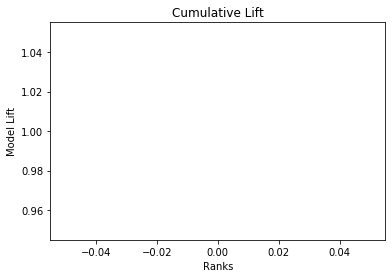

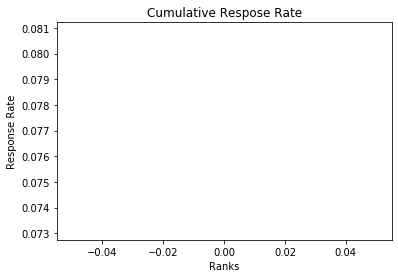

In [57]:
from imp import reload 
import Model
reload(Model)

Lift = Model.ModelLift(c=10)
lift = Lift.calLift(pred, target='target', prob='prob')
Model.Plot(lift)